In [1]:
import pandas as pd
import sklearn
import joblib
import matplotlib.pyplot as plt
from feature_engine.datetime import DatetimeFeatures
import numpy as np



In [2]:
pd.set_option("display.max_columns",None)

In [3]:
sklearn.set_config(transform_output="default")

In [4]:
train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
val_df=pd.read_csv("data/val.csv")

In [5]:
train_df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Vistara,2019-04-15,Banglore,Delhi,09:45:00,12:35:00,170,0.0,No Info,5403
1,Jet Airways,2019-03-18,Banglore,New Delhi,11:40:00,07:40:00,1200,1.0,No Info,12284
2,Jet Airways,2019-05-03,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,No Info,8040
3,Indigo,2019-04-03,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info,4077
4,Jet Airways,2019-05-12,Kolkata,Banglore,16:30:00,18:15:00,1545,1.0,In-flight meal not included,10844


### split the data

In [6]:
def split_data(data):
    X=data.drop(columns="price")
    y=data.price.copy()
    return (X,y)

In [7]:
X_train,y_train=split_data(train_df)
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Vistara,2019-04-15,Banglore,Delhi,09:45:00,12:35:00,170,0.0,No Info
1,Jet Airways,2019-03-18,Banglore,New Delhi,11:40:00,07:40:00,1200,1.0,No Info
2,Jet Airways,2019-05-03,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,No Info
3,Indigo,2019-04-03,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info
4,Jet Airways,2019-05-12,Kolkata,Banglore,16:30:00,18:15:00,1545,1.0,In-flight meal not included
...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-21,Kolkata,Banglore,14:05:00,22:35:00,510,1.0,No Info
636,Jet Airways,2019-05-12,Banglore,Delhi,07:10:00,10:10:00,180,0.0,In-flight meal not included
637,Jet Airways,2019-05-03,Banglore,Delhi,08:20:00,11:20:00,180,0.0,In-flight meal not included
638,Vistara,2019-04-01,Kolkata,Banglore,07:10:00,22:55:00,945,1.0,No Info


In [8]:
X_val,y_val=split_data(val_df)
X_test,y_test=split_data(test_df)

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


# Data Preprocessing

In [10]:
dt_cols=["date_of_journey","dep_time","arrival_time"]
num_cols=["total_stops","duration"]
cat_cols=["airline","source","destination","additional_info"]

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler ,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [12]:
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
	("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
	("scaler", StandardScaler())
])

In [13]:
preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols),
	("doj", doj_transformer, ["date_of_journey"]),
	("time", time_transformer, ["dep_time", "arrival_time"])
])


In [14]:
preprocessor.fit_transform(X_train)

array([[-1.20580168, -0.92949383,  0.        , ...,  1.07783711,
        -0.19553469,  0.63835928],
       [ 0.23935389,  1.02521277,  0.        , ...,  0.81201216,
        -0.92736043,  0.93722536],
       [-1.20580168, -1.0813157 ,  0.        , ..., -0.25128765,
        -0.34189984,  1.53495753],
       ...,
       [-1.20580168, -0.91051609,  0.        , ..., -0.25128765,
        -0.34189984, -0.25823898],
       [ 0.23935389,  0.54128056,  0.        , ..., -0.78293755,
         1.26811679,  1.83382361],
       [ 0.23935389, -0.83460516,  0.        , ...,  0.5461872 ,
         1.41448194, -0.55710506]])

In [30]:
preprocessor.fit_transform(X_train).shape

(640, 35)

### model_selection

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures
from xgboost import XGBRegressor

In [17]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}


In [18]:
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [19]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [20]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)
    # training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

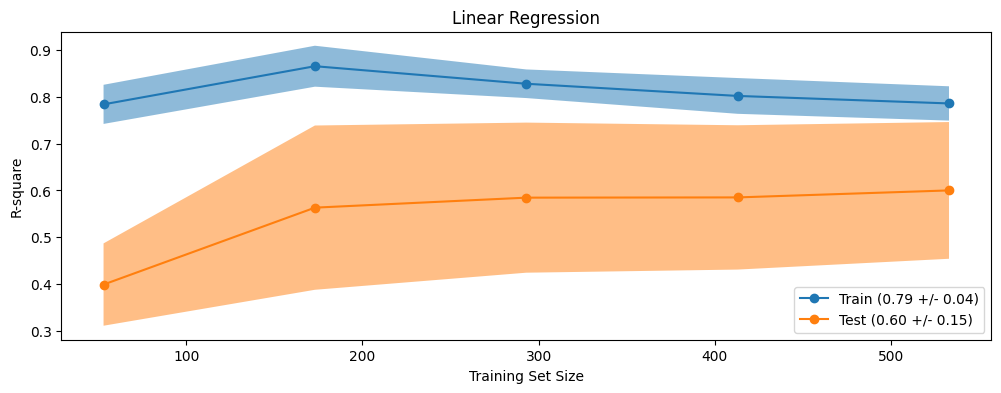

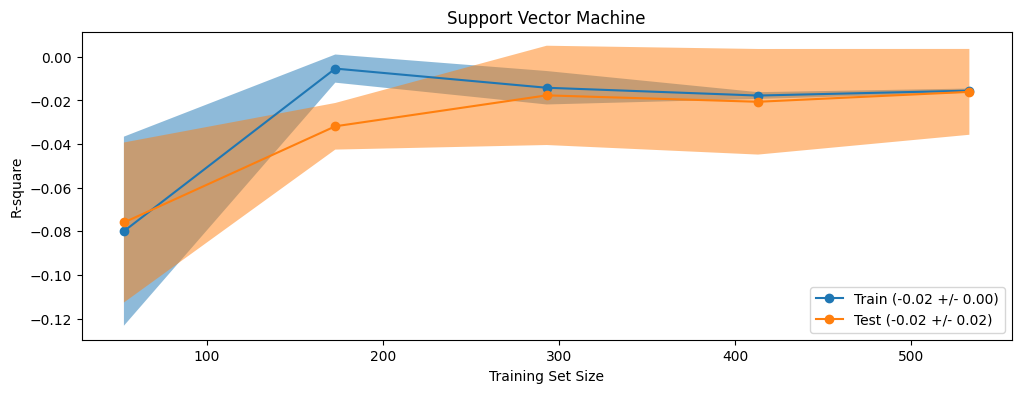

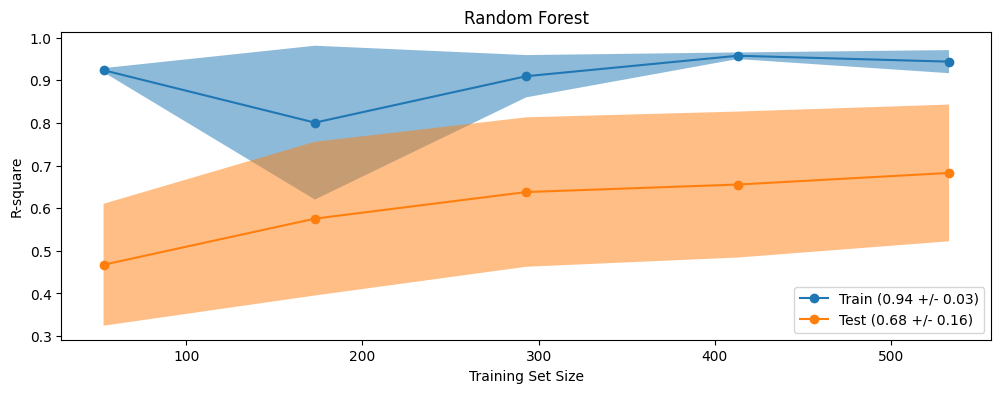

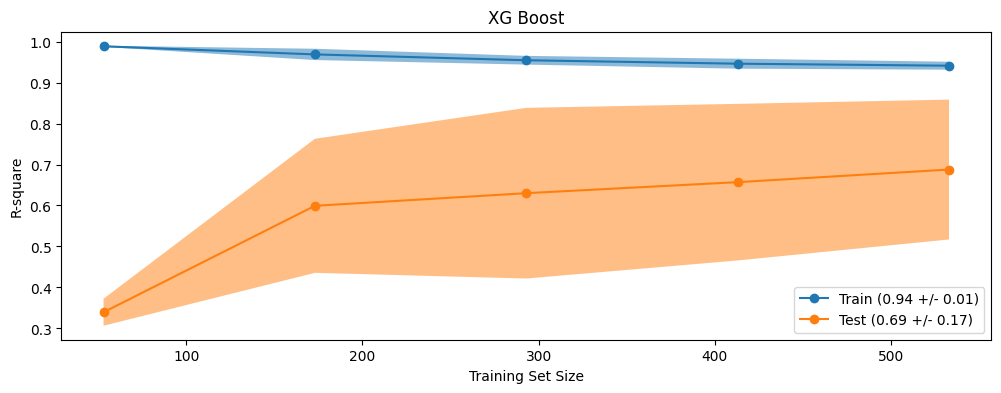

In [21]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)


## model training

In [22]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [23]:
model.fit(X_data, y_data)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_stops', 'duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

### model evaluation

In [24]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [25]:
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")

R2 score on Training data is = 0.9164290185692102


In [26]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")

R2 score on Test data is = 0.7492900296284889


## model persistence

In [27]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [28]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_stops', 'duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [29]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.7492900296284889